# Titanic survival prediction

Lets's start by trying to study the data and the raltions the target attribute has with the predictive attributes. 

In [35]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

In [6]:
test = pd.read_csv('input_data\\test.csv')
train = pd.read_csv('input_data\\train.csv')

In [9]:
print(train.columns)
train.head()

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


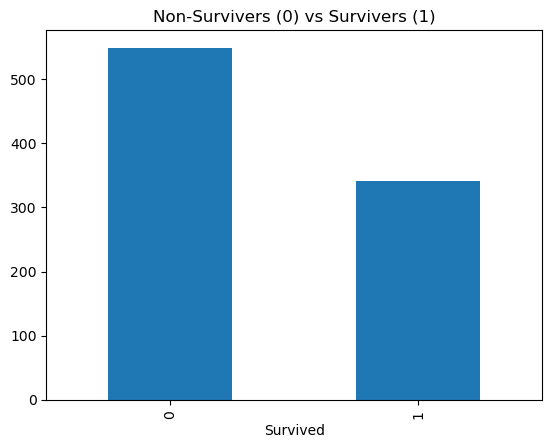

In [13]:
train['Survived'].value_counts().plot(kind='bar')
plt.title("Non-Survivers (0) vs Survivers (1)")
plt.show()

#pretty balanced dataset, that's good

Sex
female    314
male      577
Name: Survived, dtype: int64
Percentage of survivals per gender: 
 Sex
female    74.203822
male      18.890815
Name: Survived, dtype: float64


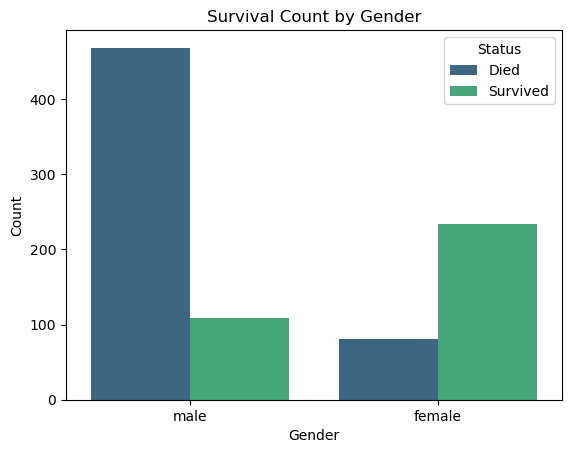

In [ ]:
n = train.groupby('Sex')['Survived']
print(n.size())
print(f"Percentage of survivals per gender: \n {n.mean() * 100}")

sns.countplot(x='Sex', hue='Survived', data=train, palette='viridis')

plt.title('Survival Count by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Status', labels=['Died', 'Survived']) 
plt.show()

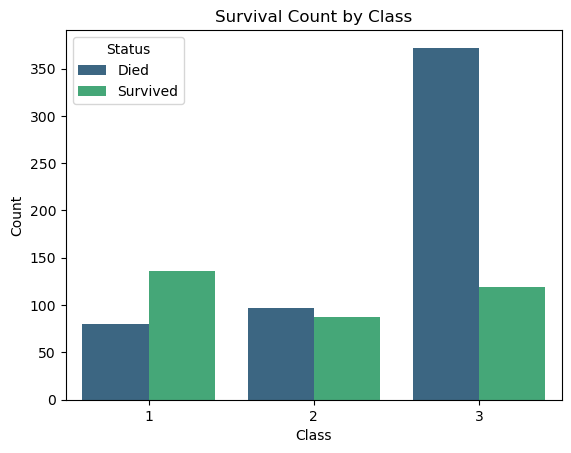

Percentage of survivors per class: 
 Pclass
1    62.962963
2    47.282609
3    24.236253
Name: Survived, dtype: float64
Percentage of passengers per class: 
 Pclass
1    24.242424
2    20.650954
3    55.106622
dtype: float64


In [52]:
sns.countplot(x='Pclass', hue='Survived', data=train, palette='viridis')

plt.title('Survival Count by Class')
plt.xlabel('Class')
plt.ylabel('Count')
plt.legend(title='Status', labels=['Died', 'Survived']) 
plt.show()

print(f"Percentage of survivors per class: \n {train.groupby('Pclass')['Survived'].mean() *100}")

print(f"Percentage of passengers per class: \n {train.groupby('Pclass').size()/  train.shape[0] * 100}")

Interesting that even though the 3rd class made up more than half of the passengers, they still have the lowest survival percentage. 

C:\Users\Utilizador\AppData\Local\Temp\ipykernel_1580\3422365814.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(data=train, x='Age', fill=True, common_norm=False, palette='viridis')


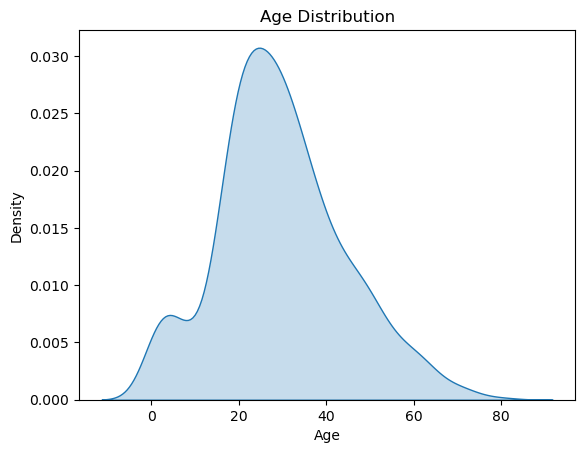

In [55]:
sns.kdeplot(data=train, x='Age', fill=True, common_norm=False, palette='viridis')

plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Density')
plt.show()

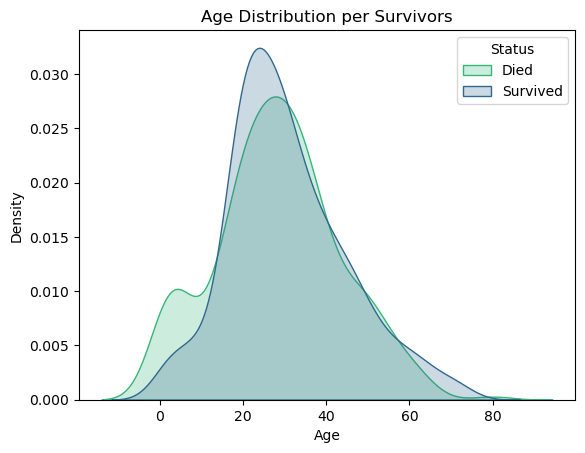

In [ ]:
sns.kdeplot(data=train, x='Age', hue='Survived', fill=True, common_norm=False, palette='viridis')

plt.title('Age Distribution per Survivors')
plt.xlabel('Age')
plt.ylabel('Density')
plt.legend(title='Status', labels=['Died', 'Survived'])
plt.show()

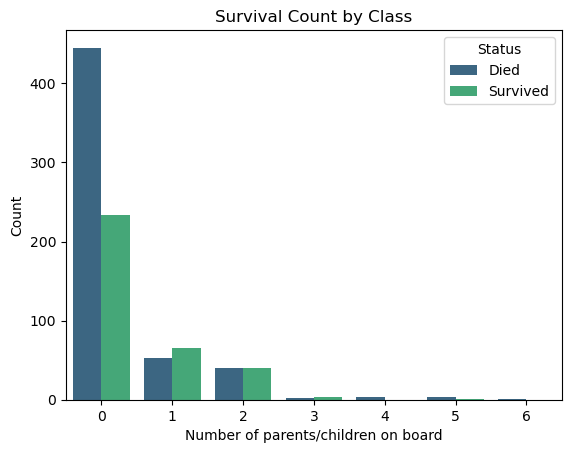

Count of people with different parents/children number: 
 Parch
0    678
1    118
2     80
3      5
4      4
5      5
6      1
dtype: int64
Percentage of survivors per class: 
 Parch
0    34.365782
1    55.084746
2    50.000000
3    60.000000
4     0.000000
5    20.000000
6     0.000000
Name: Survived, dtype: float64
Percentage of passengers per class: 
 Parch
0    76.094276
1    13.243547
2     8.978676
3     0.561167
4     0.448934
5     0.561167
6     0.112233
dtype: float64


In [60]:
sns.countplot(x='Parch', hue='Survived', data=train, palette='viridis')

plt.title('Survival Count by Class')
plt.xlabel('Number of parents/children on board')
plt.ylabel('Count')
plt.legend(title='Status', labels=['Died', 'Survived']) 
plt.show()

print(f"Count of people with different parents/children number: \n {train.groupby('Parch').size()}")

print(f"Percentage of survivors per class: \n {train.groupby('Parch')['Survived'].mean() *100}")

print(f"Percentage of passengers per class: \n {train.groupby('Parch').size()/  train.shape[0] * 100}")

For the big number of children/parents, since there's so little cases, the results should not be very explanatory.  


In [ ]:
sns.kdeplot(data=train, x='Fare', hue='Survived', fill=True, common_norm=False, palette='viridis')

plt.title('Age Distribution per Survivors')
plt.xlabel('Age')
plt.ylabel('Density')
plt.legend(title='Status', labels=['Died', 'Survived'])
plt.show()